In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [2]:
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.2.0
    Uninstalling Pillow-5.2.0:
      Successfully uninstalled Pillow-5.2.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
import numpy as np
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [4]:
import os
os.getcwd()

'/content'

In [0]:
device = torch.device("cuda")

In [0]:
loader = transforms.Compose([transforms.Resize([512,512]),transforms.ToTensor()])

In [0]:
def img_loader(path):
  #Resizes and returns as a tensor
  image = Image.open(path)
  #Network needs an input batch size (which is 1 here)
  image = loader(image).unsqueeze(0)
  return image.to(device,torch.float)

In [0]:
def show_image(imgTensor,title):
  pic = imgTensor.cpu().clone()
  pic = pic.squeeze(0) #Removing batch number
  conv_PIL = transforms.ToPILImage()
  pic = conv_PIL(pic) #matplotlib takes PIL Input
  plt.imshow(pic)
  plt.title(title)
  plt.pause(0.001) #updating plots

In [0]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [83]:
upload_files()

Saving Screenshot (6).jpg to Screenshot (6) (1).jpg
Saving anim.jpg to anim (3).jpg


['Screenshot (6).jpg', 'anim.jpg']

In [0]:
content = img_loader('Screenshot (6).jpg')

In [0]:
style = img_loader('anim.jpg')

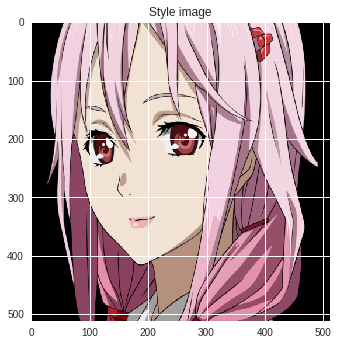

In [86]:
plt.figure()
show_image(style,'Style image')

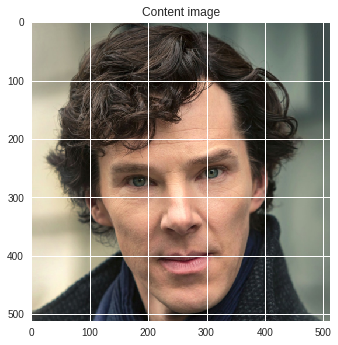

In [87]:
plt.figure()
show_image(content,'Content image')

In [0]:
class ContentLoss(nn.Module):    
    # Module computes the loss and stores it. returns gen as 
    # input is not to be changed
    def __init__(self,target):
        super(ContentLoss,self).__init__()
        # Since target is not a variable (we don't want to change the values of content image)
        self.target = target.detach()

    def forward(self, gen):
        self.loss = F.mse_loss(gen,self.target)
        return gen

In [0]:
def grammatrix(mat):
  #Gives the correlation matrix between channels (size c x c)
  b,c,h,w = mat.size()
  trans = mat.view(b*c,h*w)
  return (torch.mm(trans,trans.t())/(b*c*h*w)) 

In [0]:
class StyleLoss(nn.Module):
    # Module computes the loss and stores it. returns gen as 
    # input is not to be changed
    def __init__(self,target):
        super(StyleLoss,self).__init__()
        # Since target is not a variable (we don't want to change the values of Style image)
        self.target_grammat = grammatrix(target.detach())

    def forward(self, gen):
        self.loss = F.mse_loss(grammatrix(gen),self.target_grammat)
        return gen

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
#eval -> Using as a feature generator


In [0]:
#VGGnet normalization parameters for each channel.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)

In [0]:
class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        # since params are given for seperate channels:
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self,img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn,normalization_mean,normalization_std,style_img, content_img,content_layers=content_layers_default,style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    # declaring input normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # Making losses iterable
    content_losses = []
    style_losses = []

    # Initializing sequential model with input normalizer.
    # Model is similar to the VGG19 model with no backprop and loss modules
    # added where ever required.
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            # pass content image through the model and then 
            # define content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:            
            # pass style image through the model and then 
            # define style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
        # Any extra layers after the last loss layer are removed
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
        
        model = model[:(i + 1)]

        return model,style_losses,content_losses

In [0]:
gen_image = content.clone()

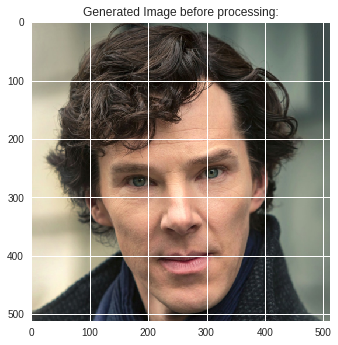

In [94]:
show_image(gen_image,'Generated Image before processing:')

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def optimiz(cnn,normalization_mean,normalization_std,content,style,gen_image,num_steps=400,style_weight=1000000,content_weight=1):
    model,style_losses,content_losses = get_style_model_and_losses(cnn,normalization_mean,normalization_std,style,content)
    optimizer = optim.LBFGS([gen_image.requires_grad_()])
    
    run = [0]
    while run[0] <= num_steps:
      def closure():
        # pre-normalizing:
        gen_image.data.clamp_(0,1)
        optimizer.zero_grad()
        model(gen_image)
        net_style_loss,net_content_loss=0,0

        for sloss in style_losses:
          net_style_loss+=sloss.loss

        for closs in content_losses:
          net_content_loss+=closs.loss

        net_style_loss *= style_weight
        net_content_loss *= content_weight
        loss = net_style_loss+net_content_loss
        loss.backward()   
        run[0] += 1
        if run[0] % 50 == 0:
          print("step {}:".format(run[0]))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              net_style_loss,net_content_loss))
          print()
        return net_style_loss + net_content_loss
      optimizer.step(closure)

    gen_image.data.clamp_(0, 1)
    
    return gen_image

In [102]:
end_image = optimiz(cnn,cnn_normalization_mean,cnn_normalization_std,content,style,gen_image)

step 50:
Style Loss : 9.845927 Content Loss: 26.718782

step 100:
Style Loss : 5.230736 Content Loss: 26.091227

step 150:
Style Loss : 3.929394 Content Loss: 25.752346

step 200:
Style Loss : 5.520819 Content Loss: 25.516832

step 250:
Style Loss : 3.621593 Content Loss: 25.395790

step 300:
Style Loss : 23.212328 Content Loss: 25.379208

step 350:
Style Loss : 10.714394 Content Loss: 25.813389

step 400:
Style Loss : 3.694594 Content Loss: 25.299253



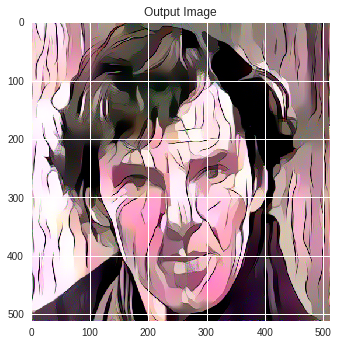

In [98]:

plt.figure()
show_image(gen_image, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()